In [1]:
# -*- coding: utf-8 -*-
# This is a report using the data from IQAASL.
# IQAASL was a project funded by the Swiss Confederation
# It produces a summary of litter survey results for a defined region.
# These charts serve as the models for the development of plagespropres.ch
# The data is gathered by volunteers.
# Please remember all copyrights apply, please give credit when applicable
# The repo is maintained by the community effective January 01, 2022
# There is ample opportunity to contribute, learn and teach
# contact dev@hammerdirt.ch

# Dies ist ein Bericht, der die Daten von IQAASL verwendet.
# IQAASL war ein von der Schweizerischen Eidgenossenschaft finanziertes Projekt.
# Es erstellt eine Zusammenfassung der Ergebnisse der Littering-Umfrage für eine bestimmte Region.
# Diese Grafiken dienten als Vorlage für die Entwicklung von plagespropres.ch.
# Die Daten werden von Freiwilligen gesammelt.
# Bitte denken Sie daran, dass alle Copyrights gelten, bitte geben Sie den Namen an, wenn zutreffend.
# Das Repo wird ab dem 01. Januar 2022 von der Community gepflegt.
# Es gibt reichlich Gelegenheit, etwas beizutragen, zu lernen und zu lehren.
# Kontakt dev@hammerdirt.ch

# Il s'agit d'un rapport utilisant les données de IQAASL.
# IQAASL était un projet financé par la Confédération suisse.
# Il produit un résumé des résultats de l'enquête sur les déchets sauvages pour une région définie.
# Ces tableaux ont servi de modèles pour le développement de plagespropres.ch
# Les données sont recueillies par des bénévoles.
# N'oubliez pas que tous les droits d'auteur s'appliquent, veuillez indiquer le crédit lorsque cela est possible.
# Le dépôt est maintenu par la communauté à partir du 1er janvier 2022.
# Il y a de nombreuses possibilités de contribuer, d'apprendre et d'enseigner.
# contact dev@hammerdirt.ch

# sys, file and nav packages:
import datetime as dt
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, get_month_names
import locale

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from math import pi

# charting:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator
import seaborn as sns

# the module that has all the methods for handling the data
import resources.featuredata as featuredata

# home brew utitilties
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
from IPython.display import Markdown as md
from myst_nb import glue

# chart style
sns.set_style("whitegrid")

# colors for gradients
cmap2 = ck.cmap2
colors_palette = ck.colors_palette
bassin_pallette = featuredata.bassin_pallette


# border and row shading fro tables
a_color = "saddlebrown"
table_row = "saddlebrown"

## !! Begin Note book variables !!
# There are two language variants: german and english
# change both: date_lang and language
date_lang =  'de_DE.utf8'
locale.setlocale(locale.LC_ALL, date_lang)

# the date format of the survey data is defined in the module
date_format = featuredata.date_format

# the language setting use lower case: en or de
# changing the language may require changing the unit label
language = "de"
unit_label = "p/100 m"

# the standard date format is "%Y-%m-%d" if your date column is
# not in this format it will not work.
# these dates cover the duration of the IQAASL project
start_date = "2020-03-01"
end_date ="2021-05-31"
start_end = [start_date, end_date]

# the fail rate used to calculate the most common codes is
# 50% it can be changed:
fail_rate = 50

# Changing these variables produces different reports
# Call the map image for the area of interest
bassin_map = "resources/maps/survey_areas/aare_scaled.jpeg"

# the label for the aggregation of all data in the region
top = "Alle Erhebungsgebiete"

# define the feature level and components
# the feature of interest is the Aare (aare) at the river basin (river_bassin) level.
# the label for charting is called 'name'
this_feature = {'slug':'all', 'name':"Alle Erhebungsgebiete", 'level':'all'}

# these are the smallest aggregated components
# choices are water_name_slug=lake or river, city or location at the scale of a river bassin 
# water body or lake maybe the most appropriate
this_level = 'river_bassin'

# identify the lakes of interest for the survey area
lakes_of_interest = ["neuenburgersee", "thunersee", "bielersee", "brienzersee"]

# !! End note book variables !!

## data
# Survey location details (GPS, city, land use)
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
# set the index of the beach data to location slug
dfBeaches.set_index("slug", inplace=True)

# Survey dimensions and weights
dfDims = pd.read_csv("resources/corrected_dims.csv")

# code definitions
dxCodes = pd.read_csv("resources/codes_with_group_names")
dxCodes.set_index("code", inplace=True)

# columns that need to be renamed. Setting the language will automatically
# change column names, code descriptions and chart annotations
columns={"% to agg":"% agg", "% to recreation": "% recreation", "% to woods":"% woods", "% to buildings":"% buildings", "p/100m":"p/100 m"}

# key word arguments to construct feature data
# !Note the water type allows the selection of river or lakes
# if None then the data is aggregated together. This selection
# is only valid for survey-area reports or other aggregated data
# that may have survey results from both lakes and rivers.
fd_kwargs ={
    "filename": "resources/checked_sdata_eos_2020_21.csv",
    "feature_name": this_feature['slug'], 
    "feature_level": this_feature['level'], 
    "these_features": this_feature['slug'], 
    "component": this_level, 
    "columns": columns, 
    "language": 'de', 
    "unit_label": unit_label, 
    "fail_rate": fail_rate,
    "code_data":dxCodes,
    "date_range": start_end,
    "water_type": None,    
}

fdx = featuredata.Components(**fd_kwargs)

# call the reports and languages
fdx.adjustForLanguage()
fdx.makeFeatureData()
fdx.locationSampleTotals()
fdx.makeDailyTotalSummary()
fdx.materialSummary()
fdx.mostCommon()
# !this is the feature data!
fd = fdx.feature_data

# the period data is all the data that was collected
# during the same period from all the other locations
# not included in the feature data for a survey area
# or river bassin the parent and feature level are the
# the same.
period_kwargs = {
    "period_data": fdx.period_data,
    "these_features": this_feature['slug'],
    "feature_level":this_feature['level'],
    "feature_parent":this_feature['slug'],
    "parent_level": this_feature['level'],
    "period_name": top,
    "unit_label": unit_label,
    "most_common": fdx.most_common.index
}
period_data = featuredata.PeriodResults(**period_kwargs)

# the rivers are considered separately
# select only the results from rivers
fd_kwargs.update({"water_type":"r"})
fdr = featuredata.Components(**fd_kwargs)
fdr.makeFeatureData()
fdr.adjustForLanguage()
fdr.makeFeatureData()
fdr.locationSampleTotals()
fdr.makeDailyTotalSummary()
fdr.materialSummary()
fdr.mostCommon()

# collects the summarized values for the feature data
# use this to generate the summary data for the survey area
# and the section for the rivers
admin_kwargs = {
    "data":fd,
    "dims_data":dfDims,
    "label": this_feature["name"],
    "feature_component": this_level,
    "date_range":start_end,
    **{"dfBeaches":dfBeaches}
}
admin_details = featuredata.AdministrativeSummary(**admin_kwargs)
admin_summary = admin_details.summaryObject()
admin_r_details = featuredata.AdministrativeSummary(data=fdr.feature_data, dims_data=dfDims, label=this_feature["name"], feature_component=this_level, date_range=start_end, **{"dfBeaches":dfBeaches})

admin_kwargs.update({"data":fdr.feature_data})
admin_r_details = featuredata.AdministrativeSummary(**admin_kwargs)
admin_r_summary = admin_r_details.summaryObject()

(allsurveysde)=
# Seen und Fliessgewässer

Karte der Erhebungsorte IQAASL März 2020 - Mai 2021.

```{figure} resources/maps/lakes_rivers_map.jpeg
:figwidth: 800px
:name: "eosmap_de"

` `
```
{numref}`Abbildung {number} <eosmap_de>`: Die Erhebungsorte sind für die Analyse nach Erhebungsgebiet gruppiert. Die Grösse der Markierung gibt einen Hinweis auf die Anzahl Abfallobjekte, die gefunden wurden. 

In [2]:
rivers = admin_details.riversOfInterest()
lakes = admin_details.lakesOfInterest()
        
# string objects for display
obj_string = featuredata.thousandsSeparator(admin_summary["quantity"], language)
surv_string = "{:,}".format(admin_summary["loc_date"])
pop_string = featuredata.thousandsSeparator(int(admin_summary["population"]), language)

# make strings
date_quantity_context = F"Im Zeitraum von {featuredata.dateToYearAndMonth(datetime.strptime(start_date, date_format), lang=date_lang)}  bis {featuredata.dateToYearAndMonth(datetime.strptime(end_date, date_format), lang= date_lang)} wurden im Rahmen von {surv_string} Datenerhebungen insgesamt {obj_string } Objekte entfernt und identifiziert."
geo_context = F"Die Ergebnisse Erhebungsgebiete umfassen {admin_summary['location']} Orte, {admin_summary['city']} Gemeinden und eine Gesamtbevölkerung von etwa {pop_string} Einwohnenden."

# lists of landmarks of interest
munis_joined = ", ".join(sorted(admin_details.populationKeys()["city"]))
lakes_joined = ", ".join(sorted(lakes))
rivers_joined = ", ".join(sorted(rivers))

# put that all together:
lake_string = F"""
{date_quantity_context} {geo_context }

*Seen:*\n\n>{lakes_joined}

*Fliessgewässer:*\n\n>{rivers_joined}

*Gemeinden:*\n\n>{munis_joined}
"""
md(lake_string)


Im Zeitraum von März 2020  bis Mai 2021 wurden im Rahmen von 386 Datenerhebungen insgesamt 54 744 Objekte entfernt und identifiziert. Die Ergebnisse Erhebungsgebiete umfassen 143 Orte, 77 Gemeinden und eine Gesamtbevölkerung von etwa 1 735 991 Einwohnenden.

*Seen:*

>Bielersee, Brienzersee, Lac Léman, Lago Maggiore, Lago di Lugano, Neuenburgersee, Thunersee, Vierwaldstättersee, Walensee, Zugersee, Zürichsee

*Fliessgewässer:*

>Aare, Cassarate, Dorfbach, Emme, Escherkanal, Jona, La Thièle, Limmat, Linthkanal, Maggia, Nidau-Büren-Kanal, Reuss, Rhône, Schüss, Seez, Sihl, Ticino

*Gemeinden:*

>Aarau, Allaman, Ascona, Beatenberg, Bellinzona, Bern, Biel/Bienne, Boudry, Bourg-en-Lavaux, Brienz (BE), Brissago, Brugg, Brügg, Burgdorf, Bönigen, Cheyres-Châbles, Cudrefin, Dietikon, Erlach, Estavayer, Freienbach, Gals, Gambarogno, Gebenstorf, Genève, Gland, Glarus Nord, Grandson, Hauterive (NE), Hünenberg, Kallnach, Köniz, Küsnacht (ZH), La Tour-de-Peilz, Lausanne, Lavey-Morcles, Le Landeron, Leuk, Ligerz, Locarno, Lugano, Luterbach, Lüscherz, Merenschwand, Minusio, Montreux, Neuchâtel, Nidau, Port, Préverenges, Quarten, Rapperswil-Jona, Richterswil, Riddes, Rubigen, Saint-Gingolph, Saint-Sulpice (VD), Salgesch, Schmerikon, Sion, Solothurn, Spiez, Stäfa, Thun, Tolochenaz, Unterengstringen, Unterseen, Versoix, Vevey, Vinelz, Walenstadt, Walperswil, Weesen, Weggis, Yverdon-les-Bains, Zug, Zürich


## Landnutzungsprofil

Die Erhebungsgebiete sind nach Flusseinzugsgebieten gruppiert. In diesem Bericht werden mehrere Einzugsgebiete zusammengefasst, um regionale Trends zu analysieren: 

* Aare: Emme, Aare 
* Linth: Reuss, Linth, Limmat 
* Rhône: Rhône 
* Tessin/Ceresio: Tessin, Luganersee, Lago Maggiore

Das Landnutzungsprofil zeigt, welche Nutzungen innerhalb eines Radius von 1500 m um jeden Erhebungsort dominieren. Flächen werden einer von den folgenden vier Kategorien zugewiesen:.       

* Fläche, die von Gebäuden eingenommen wird in \%
* Fläche, die dem Wald vorbehalten ist in \%
* Fläche, die für Aktivitäten im Freien genutzt wird in \%
* Fläche, die von der Landwirtschaft genutzt wird in \%

Strassen (inkl. Wege) werden als Gesamtzahl der Strassenkilometer innerhalb eines Radius von 1500 m angegeben.
Es wird zudem angegeben, wie viele Flüsse innerhalb eines Radius von 1500 m um den Erhebungsort herum in das Gewässer münden.
Das Verhältnis der gefundenen Abfallobjekte unterscheidet sich je nach Landnutzungsprofil. Das Verhältnis gibt daher einen Hinweis auf die ökologischen und wirtschaftlichen Bedingungen um den Erhebungsort.

Weitere Informationen gibt es im Kapitel [_Landnutzungsprofil_](luseprofilede)

__Verteilung der Landnutzungsmerkmale__

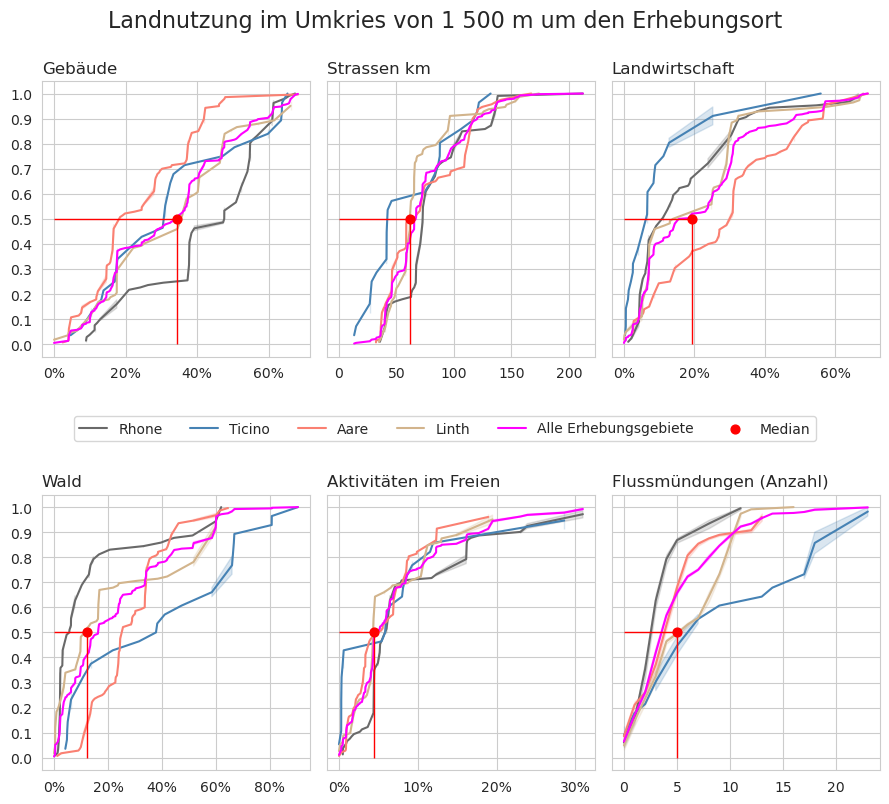

In [3]:
# this gets all the data for the project
land_use_kwargs = {
    "data": period_data.period_data,
    "index_column":"loc_date",
    "these_features": this_feature['slug'],
    "feature_level":this_level   
}

# the landuse profile of the project
project_profile = featuredata.LandUseProfile(**land_use_kwargs).byIndexColumn()

# update the kwargs for the feature data
land_use_kwargs.update({"data":fdx.feature_data})

# build the landuse profile of the feature
feature_profile = featuredata.LandUseProfile(**land_use_kwargs)

# this is the component features of the report
feature_landuse = feature_profile.featureOfInterest()

fig, axs = plt.subplots(2, 3, figsize=(9,8), sharey="row")

for i, n in enumerate(featuredata.default_land_use_columns):
    r = i%2
    c = i%3
    ax=axs[r,c]
    
    # the value of land use feature n
    # for each element of the feature
    for element in feature_landuse:
        # the land use data for a feature
        data = element[n].values
        # the name of the element
        element_name = element[feature_profile.feature_level].unique()
        # proper name for chart
        label = featuredata.river_basin_de[element_name[0]]
        # cumulative distribution        
        xs, ys = featuredata.empiricalCDF(data)
        # the plot of landuse n for this element
        sns.lineplot(x=xs, y=ys, ax=ax, label=label, color=bassin_pallette[element_name[0]])
    
    # the value of the land use feature n for the project
    testx, testy = featuredata.empiricalCDF(project_profile[n].values)
    sns.lineplot(x=testx, y=testy, ax=ax, label=top, color="magenta")
    
    # get the median landuse for the feature
    the_median = np.median(data)
    
    # plot the median and drop horizontal and vertical lines
    ax.scatter([the_median], 0.5, color="red",s=40, linewidth=1, zorder=100, label="Median")
    ax.vlines(x=the_median, ymin=0, ymax=0.5, color="red", linewidth=1)
    ax.hlines(xmax=the_median, xmin=0, y=0.5, color="red", linewidth=1)
    
    if i <= 3:
        if c == 0:            
            ax.yaxis.set_major_locator(MultipleLocator(.1))
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(1.0, 0, "%"))        
    else:
        pass      
    
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()    
    ax.set_title(featuredata.luse_de[n], loc='left')
    
plt.tight_layout()
plt.subplots_adjust(top=.91, hspace=.5)
plt.suptitle("Landnutzung im Umkries von 1 500 m um den Erhebungsort", ha="center", y=1, fontsize=16)
fig.legend(handles, labels, bbox_to_anchor=(.5,.5), loc="upper center", ncol=6) 

glue("eos_luse_de", fig, display=False)
plt.close() 

```{glue:figure} eos_luse_de
---
name: "eos_luse_de"
---

` `

```
{numref}`Abbildung {number}: <eos_luse_de>` Die Erhebungen in den Gebieten Rhône und Linth wiesen mit 47 % bzw. 40 % im Median den grössten Anteil an bebauter Fläche (Gebäude) und mit 5 % bzw. 8 % den geringsten Anteil an Wald auf. Im Erhebungsgebiet Aare war der Medianwert der bebauten Fläche (Gebäude) mit 16 % am niedrigsten und der Anteil der landwirtschaftlich genutzten Fläche mit 30 % am höchsten. Bei den Flächen, die den Aktivitäten im Freien zugeordnet werden, handelt es sich um Sportplätze, öffentliche Strände und andere öffentliche Versammlungsorte.

### Gesamtergebnisse nach Erhebungsgebiet

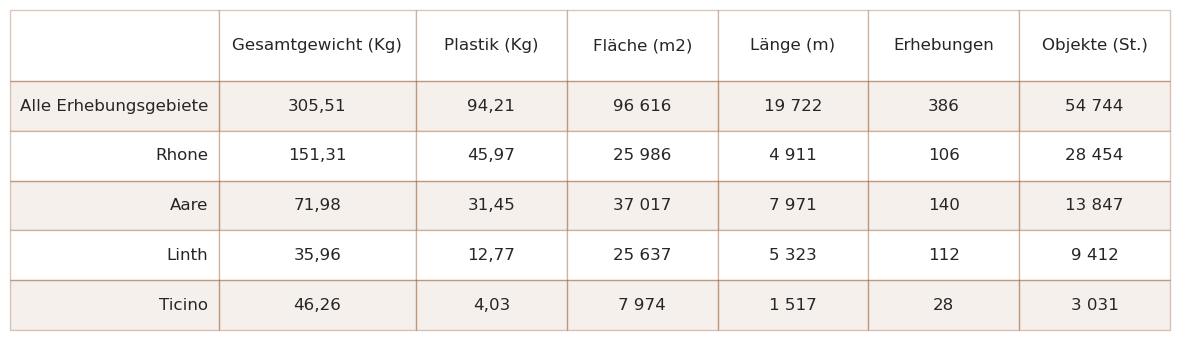

In [4]:
# the dimensional data
dims_table = admin_details.dimensionalSummary()

# a method to update the place names from slug to proper name
name_map = featuredata.river_basin_de

# the order in which they are charted
name_order = list(name_map.keys())

# sort by quantity
dims_table.sort_values(by=["quantity"], ascending=False, inplace=True)

# translating column names
dims_table.rename(columns=featuredata.dims_table_columns_de, inplace=True)

# the values in these columns need formating to swiss spec
thousands_separated = ["Fläche (m2)", "Länge (m)", "Erhebungen", "Objekte (St.)"]
replace_decimal = ["Plastik (Kg)", "Gesamtgewicht (Kg)"]
dims_table["Plastik (Kg)"] = dims_table["Plastik (Kg)"]/1000

# apply numerical formatting
dims_table[thousands_separated] = dims_table[thousands_separated].applymap(lambda x: featuredata.thousandsSeparator(int(x), "de"))
dims_table[replace_decimal] = dims_table[replace_decimal].applymap(lambda x: featuredata.replaceDecimal(str(round(x,2))))

# reset index and replace with proper names
data = dims_table.reset_index()

# replace the data slugs with the appropriate name
data["river_bassin"] = data.river_bassin.map(lambda x: featuredata.updatePlaceNames(x=x, a_map=name_map))

# the column names are the header row in the table
colLabels = data.columns

fig, ax = plt.subplots(figsize=(len(colLabels)*1.7,len(data)*.7))

sut.hide_spines_ticks_grids(ax)
table_one = sut.make_a_table(ax, data.values, colLabels=colLabels, colWidths=[.18, .17, *[.13]*5], a_color=a_color)
table_one.get_celld()[(0,0)].get_text().set_text(" ")
table_one.set_fontsize(12)

plt.tight_layout()
glue("eos_summary_sarea_de", fig, display=False)
plt.close()

```{glue:figure} eos_summary_sarea_de
:name: "eos_summary_sarea_de"


` `

```

{numref}`Abbildung {number}: <eos_summary_sarea_de>` Summen der Ergebnisse für alle Erhebungsgebiete. Im Gebiet Aare ist die Anzahl Erhebungen am grössten. Gleichzeitig ist dort die Anzahl gesammelter Objekte pro Fläche am geringsten.

## Erhebungsergebnisse für alle Objekte

Verteilung der Erhebungsergebnisse. Die Werte werden als Anzahl der identifizierten Abfallobjekte pro 100 Meter (p/100 m) dargestellt. 

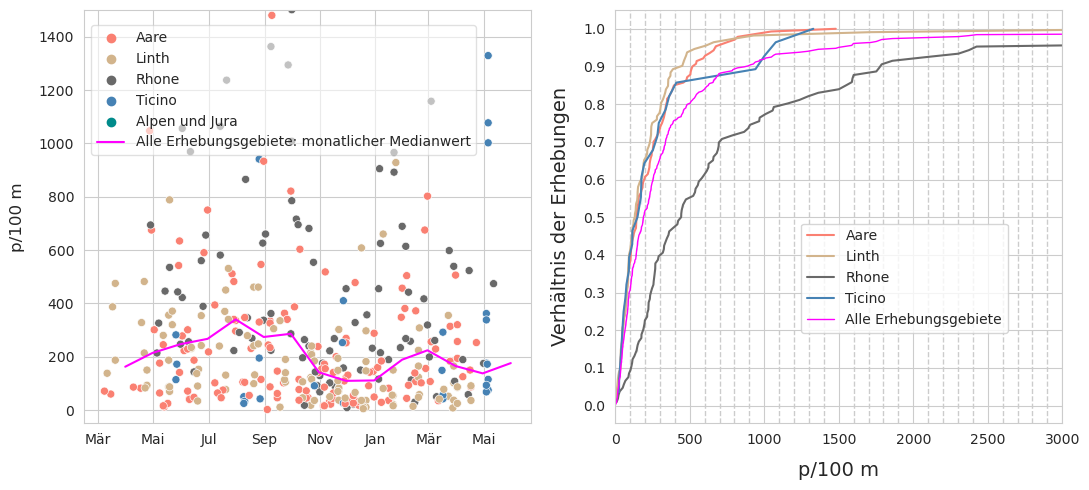

In [5]:
# the sample totals of the parent feautre
dx = period_data.parentSampleTotals(parent=False)

# get the monthly or quarterly results for the feature
rsmp = fdx.sample_totals.set_index("date")
resample_plot, rate = featuredata.quarterlyOrMonthlyValues(rsmp, this_feature["name"], vals=unit_label)

fig, axs = plt.subplots(1,2, figsize=(11,5))

ax = axs[0]

# axis notations
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter("%b")
days = mdates.DayLocator(interval=7)

# feature surveys
sns.scatterplot(data=fdx.sample_totals, x="date", y=unit_label, hue='river_bassin', hue_order=name_order, palette=bassin_pallette, s=34, ec="white", ax=ax)

# monthly or quaterly plot
sns.lineplot(data=resample_plot, x=resample_plot.index, y=resample_plot, label=F"{this_feature['name']}: monatlicher Medianwert", color="magenta", ax=ax)

# label the yaxis
ax.set_ylabel(unit_label, **{'labelpad':10, 'fontsize':12})

# label the xaxis
ax.set_xlabel("")

# format ticks and locations
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)
ax.set_ylim(-50, 1500)

# the legend labels need to be changed to proper names
h, l = ax.get_legend_handles_labels()
new_labels = [*[name_map[x] for x in l[:-1]], l[-1]]

# apply new labels and legend
ax.legend(h, new_labels, bbox_to_anchor=(0, .98), loc="upper left", ncol=1, framealpha=.6)

# the cumlative distributions:
axtwo = axs[1]

# for each survey area:
for basin in name_map.keys():
    # filter the data for the element
    mask = fdx.sample_totals.river_bassin == basin
    ecdf_data = fdx.sample_totals[mask]
    # make the ECDF and make the plot
    feature_ecd = featuredata.ecdfOfAColumn(ecdf_data, unit_label)    
    sns.lineplot(x=feature_ecd["x"], y=feature_ecd["y"], color=bassin_pallette[basin], ax=axtwo, label=name_map[basin])

# the ecdf of the parent element
other_features = featuredata.ecdfOfAColumn(dx, unit_label)
sns.lineplot(x=other_features["x"], y=other_features["y"], color="magenta", label=top, linewidth=1, ax=axtwo)

# the axist labels
axtwo.set_xlabel(unit_label, **ck.xlab_k14)
axtwo.set_ylabel("Verhältnis der Erhebungen", **ck.xlab_k14)

# set the limit of the xaxis, other wise it can go on forever
axtwo.set_xlim(0, 3000)

# set and locate the ticks on the x and y axis
axtwo.xaxis.set_major_locator(MultipleLocator(500))
axtwo.xaxis.set_minor_locator(MultipleLocator(100))
axtwo.yaxis.set_major_locator(MultipleLocator(.1))

# format the minor gridlines
axtwo.grid(which="minor", visible=True, axis="x", linestyle="--", linewidth=1)
axtwo.legend(bbox_to_anchor=(.4,.5), loc="upper left")

plt.tight_layout()

glue("eosscatter_de", fig, display=False)

plt.close()

```{glue:figure} eosscatter_de
:name: "eos_scatter_de"


` `

```

{numref}`Abbildung {number}: <eos_scatter_de>` __Links:__ Alle Erhebungen zwischen März 2020 bis Mai 2021, gruppiert nach Erhebungsgebiet und aggregiert zum monatlichen Median. Werte über 1778 p/100 m sind nicht dargestellt. __Rechts:__ Die empirische Verteilungsfunktion der Gesamtwerte der Erhebungen. 

__Abfall nach Materialarten im Überblick__

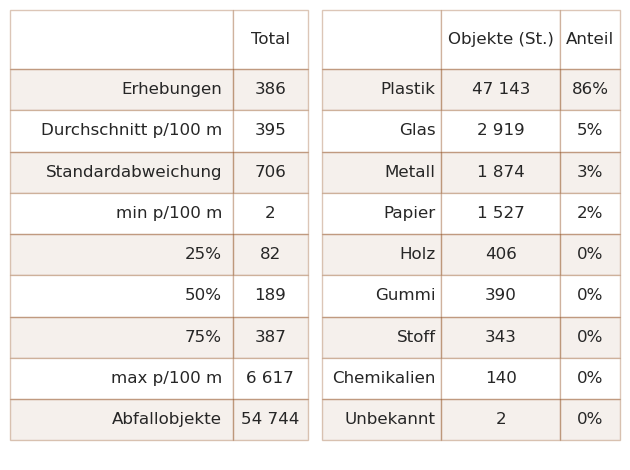

In [6]:
# the summary of the sample totals
csx = fdx.sample_summary.copy()

# format for the current language
combined_summary =[(x, featuredata.thousandsSeparator(int(csx[x]), language)) for x in csx.index]


# the materials table
fd_mat_totals = fdx.material_summary.copy()
fd_mat_totals = featuredata.fmtPctOfTotal(fd_mat_totals, around=0)

# applly new column names for printing
cols_to_use = {"material":"Material","quantity":"Objekte (St.)", "% of total":"Anteil"}
fd_mat_t = fd_mat_totals[cols_to_use.keys()].values
fd_mat_t = [(x[0], featuredata.thousandsSeparator(int(x[1]), language), x[2]) for x in fd_mat_t]

# make tables
fig, axs = plt.subplots(1,2)

# names for the table columns
a_col = [this_feature["name"], "Total"]

axone = axs[0]
sut.hide_spines_ticks_grids(axone)

table_two = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.75,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_two.get_celld()[(0,0)].get_text().set_text(" ")
table_two.set_fontsize(12)

# material table
axtwo = axs[1]
axtwo.set_xlabel(" ")
sut.hide_spines_ticks_grids(axtwo)

table_three = sut.make_a_table(axtwo, fd_mat_t,  colLabels=list(cols_to_use.values()), colWidths=[.4, .4,.2],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_three.get_celld()[(0,0)].get_text().set_text(" ")
table_three.set_fontsize(12)
plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
glue("eos_sample_material_tables", fig, display=False)
plt.close()

```{glue:figure} eos_sample_material_tables
:name: "eos_sample_material_tables"

` `
```

{numref}`Abbildung {number}: <eos_sample_material_tables>` __Links:__ Zusammenfassung der Resultate für alle Erhebungsgebiete. __Rechts:__ Materialarten in Stückzahlen und als Prozentsatz an der Gesamtmenge (Stückzahl) für alle Erhebungsgebiete.

## Die am häufigsten gefundenen Gegenstände

Die am häufigsten gefundenen Objekte sind die zehn mengenmässig am meisten vorkommenden Objekte und/oder Objekte, die in mindestens 50 % aller Datenerhebungen identifiziert wurden (Häufigkeitsrate).

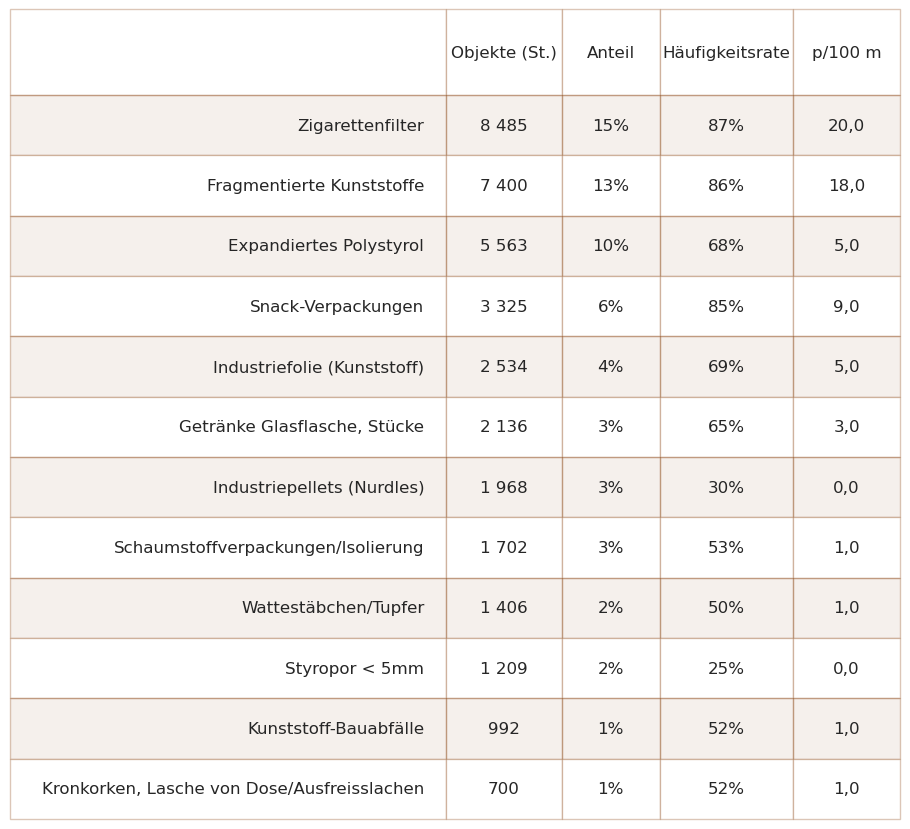

In [7]:
# the most common objects from the feature data
m_common = fdx.most_common.copy()

# format the data for printing
m_common["item"] = m_common.index.map(lambda x: fdx.dMap.loc[x])
m_common["% of total"] = m_common["% of total"].map(lambda x: F"{int(x)}%")
m_common["quantity"] = m_common.quantity.map(lambda x:featuredata.thousandsSeparator(x, language))
m_common["fail rate"] = m_common["fail rate"].map(lambda x: F"{x}%")
m_common[unit_label] = m_common[unit_label].map(lambda x: featuredata.replaceDecimal(round(x,1)))

# format the table headers
cols_to_use = featuredata.most_common_objects_table_de

# add the current units to the table header
cols_to_use.update({unit_label:unit_label})

# convert data frame to array
all_survey_areas = m_common[cols_to_use.keys()].values

fig, axs = plt.subplots(figsize=(9.2,len(m_common)*.7))

sut.hide_spines_ticks_grids(axs)

table_four = sut.make_a_table(axs, all_survey_areas,  colLabels=list(cols_to_use.values()), colWidths=[.49, .13,.11,.15, .12],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_four.get_celld()[(0,0)].get_text().set_text(" ")
table_four.set_fontsize(12)
plt.tight_layout()
glue('eos_most_common_tables', fig, display=False)
plt.close()

```{glue:figure} eos_most_common_tables
:name: "eos_most_common_tables"

` `
```
{numref}`Abbildung {number}: <eos_most_common_tables>` Die häufigsten Objekte für alle Erhebungsgebiete. Die Häufigkeitsrate gibt an, wie oft ein Objekt in den Erhebungen im Verhältnis zu allen Erhebungen identifiziert wurde: Zigarettenfilter beispielsweise wurden in 87 % der Erhebungen gefunden. Zusammengenommen machen die häufigsten Objekte 68 % aller gefundenen Objekte aus.

__Häufigste Objekte im Median p/100 m nach Erhebungsgebiet__

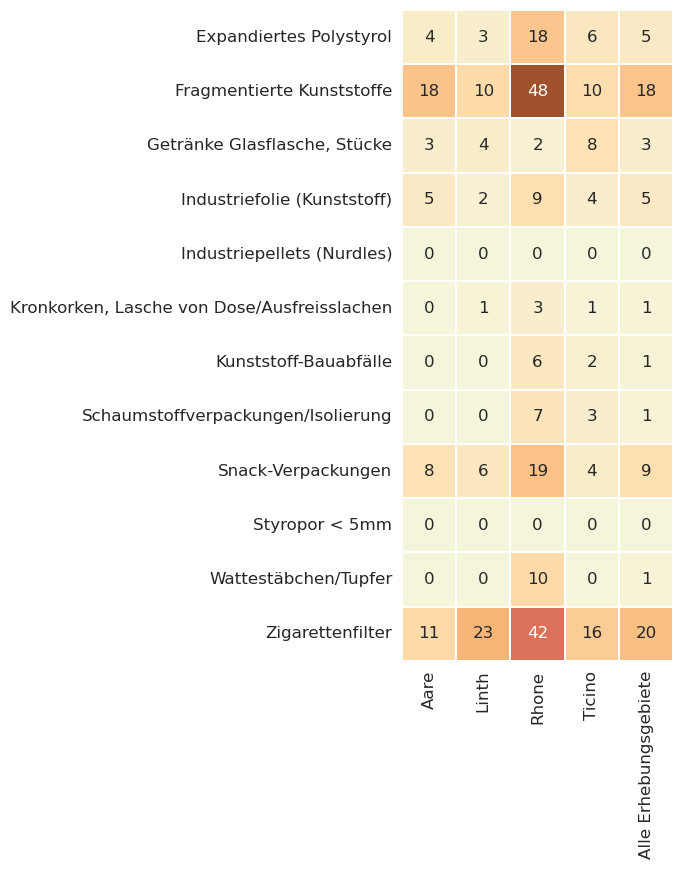

In [8]:
# map to proper names for features
feature_names = admin_details.makeFeatureNameMap()

components = fdx.componentMostCommonPcsM()

# pivot that
mc_comp = components[["item", unit_label, "river_bassin"]].pivot(columns="river_bassin", index="item")

# quash the hierarchal column index
mc_comp.columns = mc_comp.columns.get_level_values(1)

proper_column_names = {x : featuredata.updatePlaceNames(x=x, a_map=name_map)for x in mc_comp.columns}
mc_comp.rename(columns = proper_column_names, inplace=True)

# the aggregated totals for the survey area
mc_feature = fdx.most_common[unit_label]
mc_feature = featuredata.changeSeriesIndexLabels(mc_feature, {x:fdx.dMap.loc[x] for x in mc_feature.index})

# the aggregated totals of all the data
mc_period = period_data.parentMostCommon(parent=False)
mc_period = featuredata.changeSeriesIndexLabels(mc_period, {x:fdx.dMap.loc[x] for x in mc_period.index})

mc_comp[this_feature["name"]]= mc_feature
mc_comp[top] = mc_period

# chart that
fig, ax  = plt.subplots(figsize=(len(mc_comp.columns)*.7,len(mc_comp)*.8))

sns.heatmap(mc_comp, ax=ax, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".0f", square=True, cbar=False, linewidth=.1, linecolor="white")
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(labelsize=12, which="both", axis="both")

plt.setp(ax.get_xticklabels(), rotation=90)

glue("eos_common_pcs_de", fig, display=False)
plt.close()

```{glue:figure} eos_common_pcs_de
:name: "eos_common_pcs_de"

` `

```

{numref}`Abbildung {number}: <eos_common_pcs_de>` Der Median p/100 m der häufigsten Objekte für alle Erhebungsgebiete. Die Werte für die jeweiligen Erhebungsgebiete unterscheiden sich deutlich.

__Häufigste Objekte im Monatsdurchschnitt__

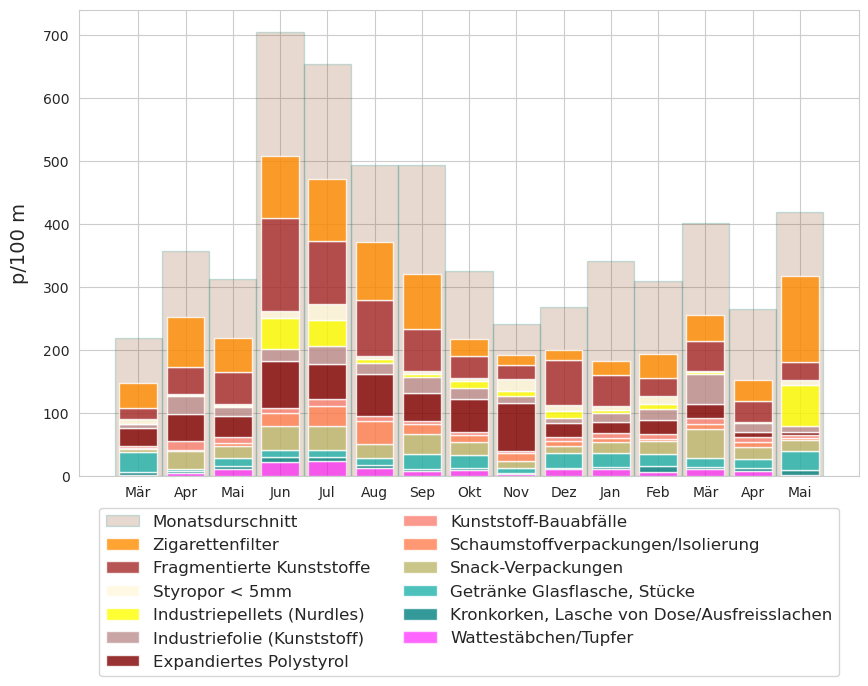

In [9]:
agg_pcs_quantity = {unit_label:"sum", "quantity":"sum"}
agg_pcs_median = {unit_label:"median", "quantity":"sum"}

# collect the survey results of the most common objects
m_common_m = fd[(fd.code.isin(m_common.index))].groupby(["loc_date","date","code", "groupname"], as_index=False).agg(agg_pcs_quantity)
m_common_m.set_index("date", inplace=True)

# set the order of the chart, group the codes by groupname columns
an_order = m_common_m.groupby(["code","groupname"], as_index=False).quantity.sum().sort_values(by="groupname")["code"].values

# a manager dict for the monthly results of each code
mgr = {}

# get the monhtly results for each code:
for a_group in an_order:
    # resample by month
    a_plot = m_common_m[(m_common_m.code==a_group)][unit_label].resample("M").mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr.update(this_group)

months={
    0:"Jan",
    1:"Feb",
    2:"Mar",
    3:"Apr",
    4:"May",
    5:"Jun",
    6:"Jul",
    7:"Aug",
    8:"Sep",
    9:"Oct",
    10:"Nov",
    11:"Dec"
}

# convenience function to lable x axis
def new_month(x):
    if x <= 11:
        this_month = x
    else:
        this_month=x-12    
    return this_month

fig, ax = plt.subplots(figsize=(9,7))

# define a bottom
bottom = [0]*len(mgr["G27"])

# the monhtly survey average for all objects and locations
monthly_fd = fd.groupby(["loc_date", "date"], as_index=False).agg(agg_pcs_quantity)
monthly_fd.set_index("date", inplace=True)
m_fd = monthly_fd[unit_label].resample("M").mean().fillna(0)

# define the xaxis
this_x = [i for i,x in  enumerate(m_fd.index)]

# plot the monthly total survey average
ax.bar(this_x, m_fd.to_numpy(), color=table_row, alpha=0.2, linewidth=1, edgecolor="teal", width=1, label="Monthly survey average") 

# plot the monthly survey average of the most common objects
for i, a_group in enumerate(an_order): 
    
    # define the axis
    this_x = [i for i,x in  enumerate(mgr[a_group].index)]
    
    # collect the month
    this_month = [x.month for i,x in enumerate(mgr[a_group].index)]
    
    # if i == 0 laydown the first bars
    if i == 0:
        ax.bar(this_x, mgr[a_group].to_numpy(), label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.6 ) 
    # else use the previous results to define the bottom
    else:
        bottom += mgr[an_order[i-1]].to_numpy()        
        ax.bar(this_x, mgr[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.8)
        
# collect the handles and labels from the legend
handles, labels = ax.get_legend_handles_labels()

# set the location of the x ticks
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))
ax.set_ylabel(unit_label, **ck.xlab_k14)

# label the xticks by month
#label the xticks by month
axisticks = ax.get_xticks()
labelsx = [sut.months_de[new_month(x-1)] for x in  this_month]
plt.xticks(ticks=axisticks, labels=labelsx)

# make the legend
# swap out codes for descriptions
new_labels = [fdx.dMap.loc[x] for x in labels[1:]]
new_labels = new_labels[::-1]

# insert a label for the monthly average
new_labels.insert(0,"Monatsdurschnitt")
handles = [handles[0], *handles[1:][::-1]]
    
plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(.5, -.05), loc="upper center",  ncol=2, fontsize=12)
plt.tight_layout()
glue("monthlyeos_de", fig, display=False)
plt.close()

```{glue:figure} monthlyeos_de
:name: "monthly_eos_de"


` `

```

{numref}`Abbildung {number}: <monthly_eos_de>` Monatliches Durchschnittsergebnis der Erhebungen als p/100 m der häufigsten Objekte für alle Erhebungsgebiete. 

## Erhebungsergebnisse und Landnutzung 

Die Erhebungsergebnisse in Bezug auf die Landnutzung auf nationaler Ebene werden in den Kapiteln [ Landnutzungsprofil ](luseprofilede) und [Geteilte Verantwortung](transportde) ausführlich erörtert.

## Verwendungszweck der gefundenen Objekte 


Der Verwendungszweck basiert auf der Verwendung des Objekts, bevor es weggeworfen wurde, oder auf der Artikelbeschreibung, wenn die ursprüngliche Verwendung unbestimmt ist. Identifizierte Objekte werden einer der 260 vordefinierten Kategorien zugeordnet. Die Kategorien werden je nach Verwendung oder Artikelbeschreibung gruppiert.

* Abwasser: Objekte, die aus Kläranlagen freigesetzt werden, sprich Objekte, die wahrscheinlich über die Toilette entsorgt werden
* Mikroplastik (< 5 mm): fragmentierte Kunststoffe und Kunststoffharze aus der Vorproduktion
* Infrastruktur: Artikel im Zusammenhang mit dem Bau und der Instandhaltung von Gebäuden, Strassen und der Wasser-/Stromversorgung
* Essen und Trinken: alle Materialien, die mit dem Konsum von Essen und Trinken in Zusammenhang stehen
* Landwirtschaft: Materialien z. B. für Mulch und Reihenabdeckungen, Gewächshäuser, Bodenbegasung, Ballenverpackungen. Einschliesslich Hartkunststoffe für landwirtschaftliche Zäune, Blumentöpfe usw.
* Tabakwaren: hauptsächlich Zigarettenfilter, einschliesslich aller mit dem Rauchen verbundenen Materialien
* Freizeit und Erholung: Objekte, die mit Sport und Freizeit zu tun haben, z. B. Angeln, Jagen, Wandern usw.
* Verpackungen ausser Lebensmittel und Tabak: Verpackungsmaterial, das nicht lebensmittel- oder tabakbezogen ist
* Plastikfragmente: Plastikteile unbestimmter Herkunft oder Verwendung
* Persönliche Gegenstände: Accessoires, Hygieneartikel und Kleidung

Im Anhang (Kapitel 1.8.3) befindet sich die vollständige Liste der identifizierten Objekte, einschliesslich Beschreibungen und Gruppenklassifizierung. Das Kapitel  [Codegruppen](codegroupsde) beschreibt jede Codegruppe im Detail und bietet eine umfassende Liste aller Objekte in einer Gruppe. 

Der Nutzungszweck oder die Beschreibung der identifizierten Objekte in % der Gesamtfläche der Erhebung. 

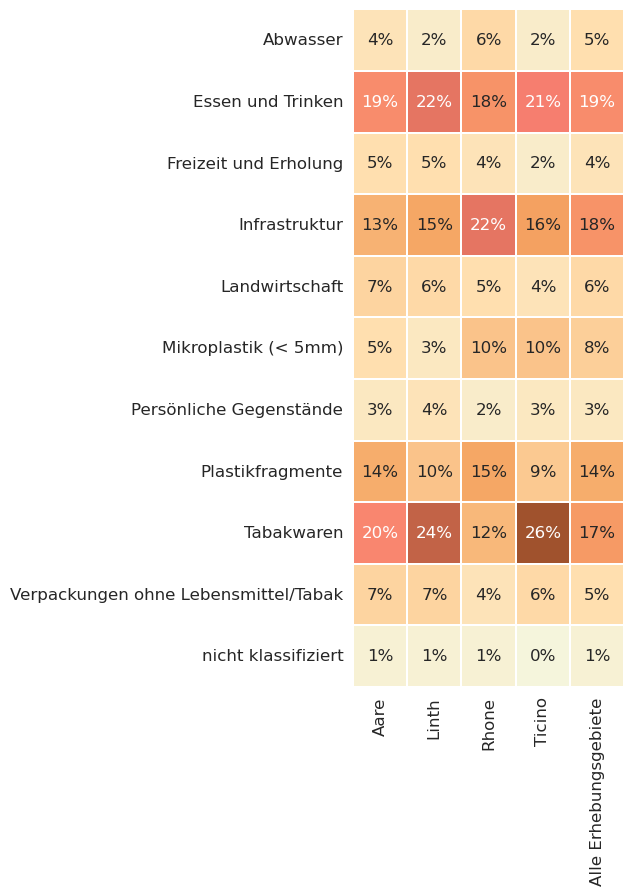

In [10]:
components = fdx.componentCodeGroupResults()

# pivot that
pt_comp = components[["river_bassin", "groupname", '% of total' ]].pivot(columns="river_bassin", index="groupname")

# quash the hierarchal column index
pt_comp.columns = pt_comp.columns.get_level_values(1)
pt_comp.rename(columns = proper_column_names, inplace=True)

# the aggregated totals for the period
pt_period = period_data.parentGroupTotals(parent=False, percent=True)
pt_comp[top] = pt_period

# make figure
fig, ax = plt.subplots(figsize=(len(pt_comp.columns)*.7,len(pt_comp)*.8))

sns.heatmap(pt_comp , ax=ax, cmap=cmap2, annot=True,  annot_kws={"fontsize":12}, fmt=".0%", cbar=False, linewidth=.1, linecolor="white")

ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(labelsize=12, which="both", axis="both", labeltop=False, labelbottom=True)

plt.setp(ax.get_xticklabels(), rotation=90)
plt.setp(ax.get_yticklabels(), rotation=0)
glue("eos_codegroup_percent", fig, display=False)

plt.close()

```{glue:figure} eos_codegroup_percent
:name: "eos_codegroup_percent"

` `
```
{numref}`Abbildung {number}: <eos_codegroup_percent>` Prozentuale Verteilung der identifizierten Objekte nach Verwendungszweck.

In [11]:
# cg_medpcm = F"""
# {top_name[0]} Verwendungszweck der gefundenen Objekte Median {unit_label}. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.
# """
# md(cg_medpcm)

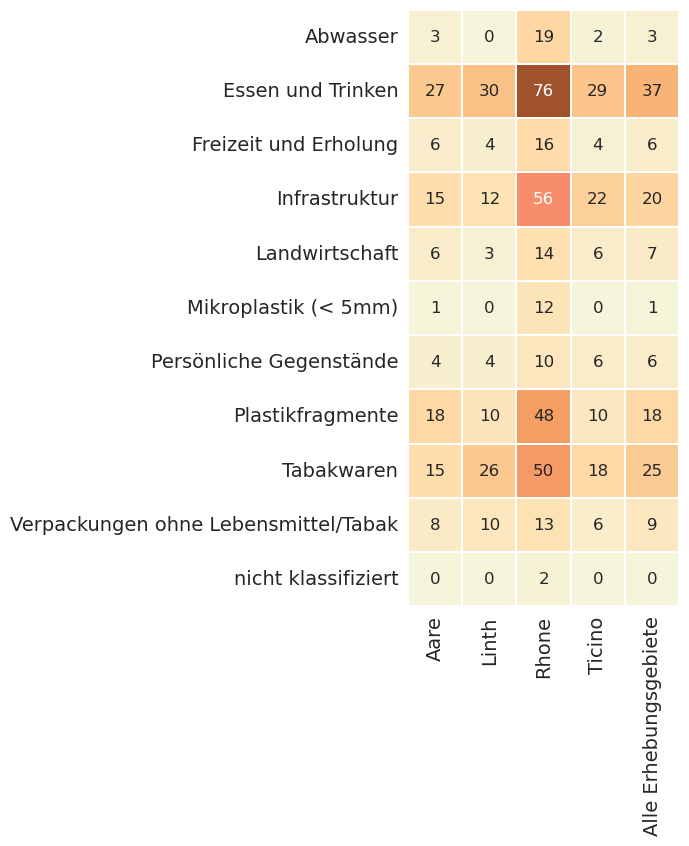

In [12]:
# pivot that
grouppcs_comp = components[["river_bassin", "groupname", unit_label ]].pivot(columns="river_bassin", index="groupname")

# quash the hierarchal column index
grouppcs_comp.columns = grouppcs_comp.columns.get_level_values(1)
grouppcs_comp.rename(columns = proper_column_names, inplace=True)

# the aggregated totals for the period
pt_period = period_data.parentGroupTotals(parent=False, percent=False)
grouppcs_comp[top] = pt_period

data = grouppcs_comp
fig, ax = plt.subplots(figsize=(len(pt_comp.columns)*.7,len(pt_comp)*.8))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".0f", cbar=False, linewidth=.1, square=True, linecolor="white")

axone.set_xlabel("")
axone.set_ylabel("")
axone.tick_params(labelsize=14, which="both", axis="both", labeltop=False, labelbottom=True)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)

glue("eos_codegroup_pcs", fig, display=False)

plt.close()

```{glue:figure} eos_codegroup_pcs
:name: "eos_codegroup_pcs"


` `

```

{numref}`Abbildung {number}: <eos_codegroup_pcs>` Das Erhebungsgebiet Rhône weist die höchsten Medianwerte für die jeweiligen Verwendungszwecke auf. Allerdings ist der prozentuale Anteil von Objekten, die mit Tabakwaren, Essen und Trinken zu tun haben, geringer als der von Objekten, die mit der Infrastruktur zu tun haben.

## Fleisgewässer

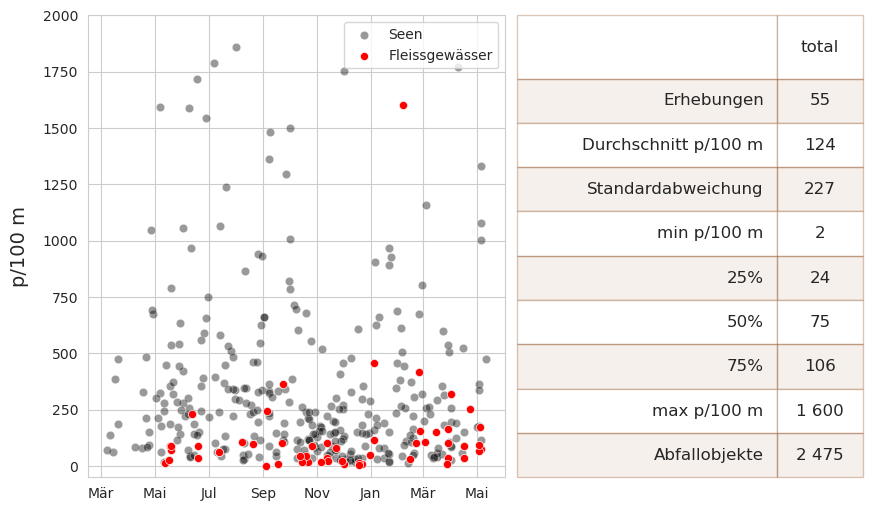

In [13]:
# summary of sample totals
rivers = fdr.sample_totals
lakes = fdx.sample_totals

csx = fdr.sample_summary.copy()
combined_summary =[(x, featuredata.thousandsSeparator(int(csx[x]), language)) for x in csx.index]

# make the charts
fig = plt.figure(figsize=(10,6))

aspec = fig.add_gridspec(ncols=11, nrows=3)

ax = fig.add_subplot(aspec[:, :6])

line_label = F"{rate} median:{top}"

sns.scatterplot(data=lakes, x="date", y=unit_label, color="black", alpha=0.4, label="Seen", ax=ax)
sns.scatterplot(data=rivers, x="date", y=unit_label, color="red", s=34, ec="white",label="Fleissgewässer", ax=ax)

ax.set_ylabel(unit_label, labelpad=10, fontsize=14)

ax.set_xlabel("")
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)
# ax.margins(x=.05, y=.05)
ax.set_ylim(-50, 2000)

a_col = [this_feature["name"], "total"]

axone = fig.add_subplot(aspec[:, 6:])
sut.hide_spines_ticks_grids(axone)

table_five = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.75,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_five.get_celld()[(0,0)].get_text().set_text(" ")
table_five.set_fontsize(12)
glue("eos_rivers", fig, display=False)

plt.close()

```{glue:figure} eos_rivers
:name: "eos_rivers"

` `
```
{numref}`Abbildung {number}: <eos_rivers>` __Links:__ Gesamtergebnisse der Erhebungen an Fliessgewässern für alle Erhebungsgebiete von März 2020 bis Mai 2021, n = 55. Werte über 2000 p/100 m sind nicht dargestellt. __Rechts:__ Zusammenfassende Daten zu Fliessgewässern.

__Die an Fliessgewässern am häufigsten gefundenen Objekte__

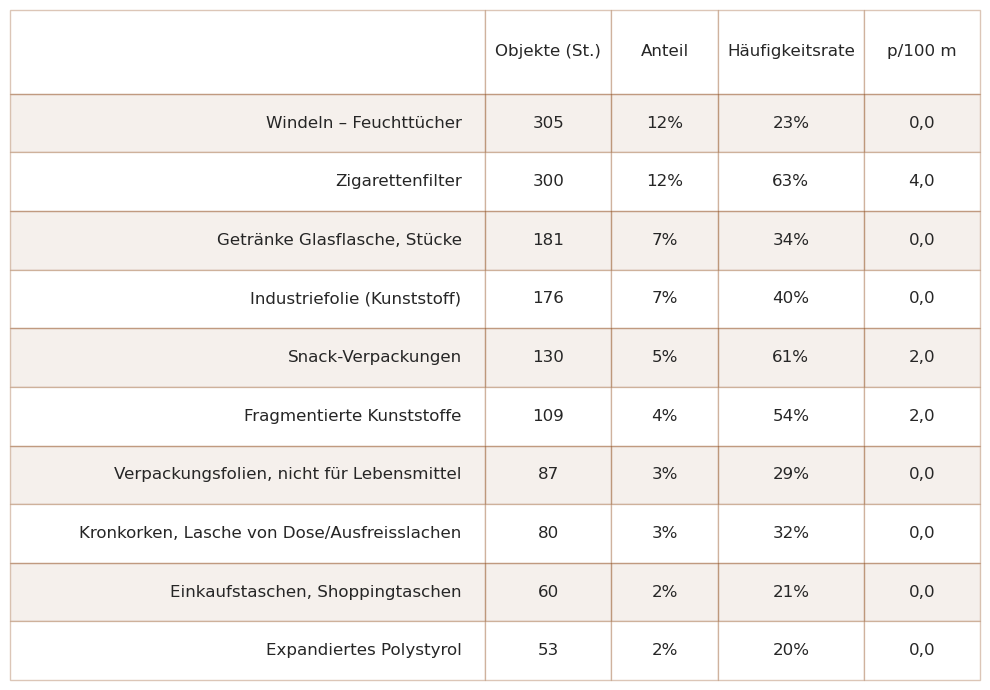

In [14]:
# format values for table
m_common = fdr.most_common.copy()
m_common["item"] = m_common.index.map(lambda x: fdx.dMap.loc[x])
m_common["% of total"] = m_common["% of total"].map(lambda x: F"{int(x)}%")
m_common["quantity"] = m_common.quantity.map(lambda x:featuredata.thousandsSeparator(x, language))
m_common["fail rate"] = m_common["fail rate"].map(lambda x: F"{x}%")
m_common[unit_label] = m_common[unit_label].map(lambda x: featuredata.replaceDecimal(round(x,1)))

# format the table headers
cols_to_use = featuredata.most_common_objects_table_de
cols_to_use.update({unit_label:unit_label})
all_survey_areas = m_common[cols_to_use.keys()].values

fig, axs = plt.subplots(figsize=(10,len(m_common)*.7))

sut.hide_spines_ticks_grids(axs)

table_four = sut.make_a_table(axs, all_survey_areas,  colLabels=list(cols_to_use.values()), colWidths=[.49, .13,.11,.15, .12],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_four.get_celld()[(0,0)].get_text().set_text(" ")
table_four.set_fontsize(12)
plt.tight_layout()
glue("eos_rivers_most_common", fig, display=False)
plt.close()

```{glue:figure} eos_rivers_most_common
:name: "eos_rivers_most_common"
` `
```
{numref}`Abbildung {number}: <eos_rivers_most_common>` Die häufigsten Objekte aus Erhebungen an Fliessgewässern. Windeln, Feuchttücher und Taschen/Tüten aus Kunststoff resp. Fragmente davon gehören nur entlang von Fliessgewässern zu den häufigsten Objekten, nicht jedoch an Ufern von Seen.

## Anhang

### Schaumstoffe und Kunststoffe nach Grösse 

Die folgende Tabelle enthält die Komponenten «Gfoam» und «Gfrag», die für die Analyse gruppiert wurden. Objekte, die als Schaumstoffe gekennzeichnet sind, werden als Gfoam gruppiert und umfassen alle geschäumten Polystyrol-Kunststoffe > 0,5 cm. Kunststoffteile und Objekte aus kombinierten Kunststoff- und Schaumstoffmaterialien > 0,5 cm werden für die Analyse als Gfrags gruppiert.

In [15]:
# frag_foams = F"""
# *{top_name[0]}  fragmentierte Kunststoffe und geschäumte Kunststoffe nach Grösse, Median p/100 m, Anzahl der Stücke und Prozent der Gesamtmenge.* 
# """
# md(frag_foams)

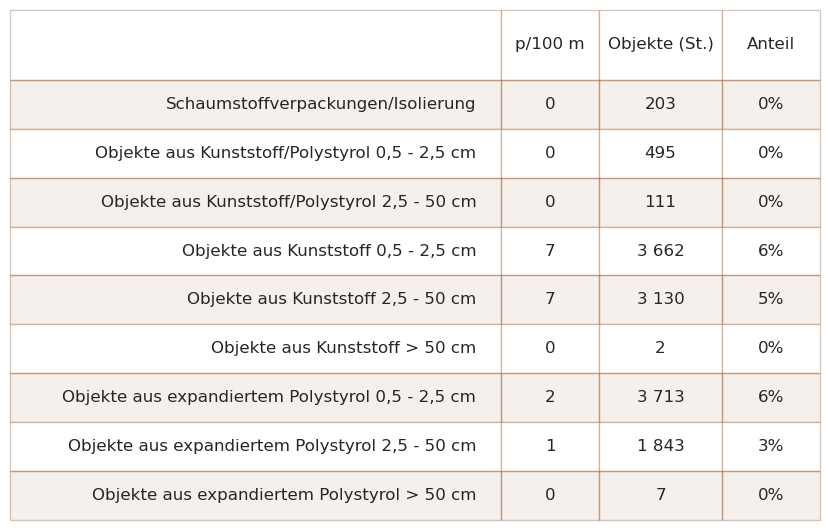

In [16]:
# collect the data before aggregating foams for all locations in the survye area
# group by loc_date and code
# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams
before_agg = pd.read_csv("resources/checked_before_agg_sdata_eos_2020_21.csv")
some_foams = ["G81", "G82", "G83", "G74"]
before_agg.rename(columns={"p/100m":unit_label}, inplace=True)
code_description_map = fdx.dMap

# the codes for the fragmented plastics
some_frag_plas = list(before_agg[before_agg.groupname == "plastic pieces"].code.unique())

fd_frags_foams = before_agg[(before_agg.code.isin([*some_frag_plas, *some_foams]))&(before_agg.location.isin(admin_summary["locations_of_interest"]))].groupby(["loc_date","code"], as_index=False).agg(agg_pcs_quantity)
fd_frags_foams = fd_frags_foams.groupby("code").agg(agg_pcs_median)

# add code description and format for printing
fd_frags_foams["item"] = fd_frags_foams.index.map(lambda x: code_description_map.loc[x])
fd_frags_foams["% of total"] = (fd_frags_foams.quantity/fd.quantity.sum()*100).round(2)
fd_frags_foams["% of total"] = fd_frags_foams["% of total"].map(lambda x: F"{int(x)}%")
fd_frags_foams["quantity"] = fd_frags_foams["quantity"].map(lambda x: featuredata.thousandsSeparator(x, language))
fd_frags_foams[unit_label] = fd_frags_foams[unit_label].astype(int)

# table data
data = fd_frags_foams[["item",unit_label, "quantity", "% of total"]]
data.rename(columns={"quantity":"Objekte (St.)", "% of total":"Anteil"}, inplace=True)

fig, axs = plt.subplots(figsize=(len(data.columns)*2.1,len(data)*.6))

sut.hide_spines_ticks_grids(axs)

table_seven = sut.make_a_table(axs,data.values,  colLabels=data.columns, colWidths=[.6, .12, .15, .12], a_color=table_row)
table_seven.get_celld()[(0,0)].get_text().set_text(" ")
table_seven.set_fontsize(12)


plt.tight_layout()
glue('eos_fragmented_plastics', fig, display=False)
plt.close()

```{glue:figure} eos_fragmented_plastics
:name: "eos_fragmented_plastics"
` `
```
{numref}`Abbildung {number}: <eos_fragmented_plastics>` Fragmentierte Kunststoffe und geschäumte Kunststoffe verschiedener Grössenordnungen nach Median p/100 m, Anzahl der gefundenen Objekte und prozentualer Anteil an der Gesamtmenge.

### Organisationen:

1. Precious Plastic Léman
2. Association pour la Sauvegarde du Léman
3. Geneva international School
4. Teilnehmende am Kurs zu Abfalltechnik (Solid waste engineering), Eidgenössische Technische Hochschule Lausanne
5. Summit Foundation
6. Ostschweizer Fachhochschule OST
7. Hackuarium
8. hammerdirt

### Die Erhebungsorte

In [17]:
# display the survey locations
pd.set_option("display.max_rows", None)
disp_columns = ["latitude", "longitude", "city"]
disp_beaches = dfBeaches.loc[admin_summary["locations_of_interest"]][disp_columns]
disp_beaches.reset_index(inplace=True)
disp_beaches.rename(columns={"city":"stat", "slug":"standort"}, inplace=True)
disp_beaches.set_index("standort", inplace=True, drop=True)

disp_beaches

,latitude,longitude,stat
standort,,,
maladaire,46.446296,6.876960,La Tour-de-Peilz
preverenges,46.512690,6.527657,Préverenges
caprino,45.987963,8.986241,Lugano
foce-del-cassarate,46.002411,8.961477,Lugano
lido,46.002004,8.962156,Lugano
lugano-centro,46.002627,8.950724,Lugano
spiaggia-parco-ciani,46.002510,8.960820,Lugano
via-brunari-spiaggia,46.202350,9.016910,Bellinzona
golene-gudo,46.170655,8.946657,Bellinzona


### Inventar der Objekte

In [18]:
pd.set_option("display.max_rows", None)
complete_inventory = fdx.code_summary.copy()
complete_inventory["quantity"] = complete_inventory["quantity"].map(lambda x: featuredata.thousandsSeparator(x, language))
complete_inventory["% of total"] = complete_inventory["% of total"].astype(int)
complete_inventory[unit_label] = complete_inventory[unit_label].astype(int)
complete_inventory.rename(columns=featuredata.inventory_table_de, inplace=True)
complete_inventory.sort_values(by="Objekte (St.)", ascending=False)

,Objekte,Objekte (St.),Anteil,p/100 m,Häufigkeitsrate,Material
code,,,,,,
G89,Kunststoff-Bauabfälle,992,1,1,52,Plastik
G914,"Büroklammern, Wäscheklammern, Gebrauchsgegenst...",99,0,0,12,Plastik
G131,Gummibänder,94,0,0,16,Gummi
G191,Draht und Gitter,90,0,0,12,Metall
G61,Sonstiges Angelzubehör,9,0,0,2,Plastik
G941,"Verpackungsfolien, nicht für Lebensmittel",894,1,0,38,Plastik
G28,"Stifte, Deckel, Druckbleistifte usw.",88,0,0,13,Plastik
G115,Schaumstoff <5mm,88,0,0,4,Plastik
G87,Abdeckklebeband/Verpackungsklebeband,87,0,0,14,Plastik
